# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Nosso objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### Importar Bibliotecas e Bases de Dados

In [2]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split


In [3]:
meses = {'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4, 'mai': 5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9,
        'out': 10, 'nov': 11, 'dez': 12}
caminho_base = pathlib.Path('dataset')
base_airbnb = pd.DataFrame()



### Consolidar Base de Dados

In [4]:
for arquivo in caminho_base.iterdir():
    nome_mes = arquivo.name[:3]
    mes = meses[nome_mes]
    
    ano = arquivo.name[-8:]
    ano = int(ano.replace('.csv', ''))
    
    df = pd.read_csv(caminho_base / arquivo.name)
    df['ano'] = ano
    df['mes'] = mes

    base_airbnb = pd.concat([base_airbnb, df])

display(base_airbnb)

C:\Users\arc_2\AppData\Local\Temp\ipykernel_13088\3877092140.py:8: DtypeWarning: Columns (62,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_base / arquivo.name)
C:\Users\arc_2\AppData\Local\Temp\ipykernel_13088\3877092140.py:8: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_base / arquivo.name)
C:\Users\arc_2\AppData\Local\Temp\ipykernel_13088\3877092140.py:8: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_base / arquivo.name)
C:\Users\arc_2\AppData\Local\Temp\ipykernel_13088\3877092140.py:8: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_base / arquivo.name)
C:\Users\arc_2\AppData\Local\Temp\ipykernel_13088\3877092140.py:8: DtypeWarning: Columns (61,62,94) have mixed types. Spe

id                            listing_url       scrape_id  \
0         14063     https://www.airbnb.com/rooms/14063  20180414160018   
1         17878     https://www.airbnb.com/rooms/17878  20180414160018   
2         24480     https://www.airbnb.com/rooms/24480  20180414160018   
3         25026     https://www.airbnb.com/rooms/25026  20180414160018   
4         31560     https://www.airbnb.com/rooms/31560  20180414160018   
...         ...                                    ...             ...   
34324  38844730  https://www.airbnb.com/rooms/38844730  20190923212307   
34325  38846408  https://www.airbnb.com/rooms/38846408  20190923212307   
34326  38846703  https://www.airbnb.com/rooms/38846703  20190923212307   
34327  38847050  https://www.airbnb.com/rooms/38847050  20190923212307   
34328  38847655  https://www.airbnb.com/rooms/38847655  20190923212307   

      last_scraped                                          name  \
0       2018-04-14                          Living in a Postcard   
1       2018-04-14             Very Nice 2Br - Copacabana - WiFi   
2       2018-04-14              Nice and cozy near Ipanema Beach   
3       2018-04-14     Beautiful Modern Decorated Studio in Copa   
4       2018-04-14              NICE & COZY 1BDR - IPANEMA BEACH   
...            ...                                           ...   
34324   2019-09-24             TRANSAMERICA BARRA DA TIJUCA R IV   
34325   2019-09-24                      Alugo para o Rock in Rio   
34326   2019-09-24  Apt COMPLETO em COPACABANA c/TOTAL SEGURANÇA   
34327   2019-09-24                     Cobertura Cinematografica   
34328   2019-09-24     Quarto em cobertura em frente à praia III   

                                                 summary  \
0      Besides the most iconic's view, our apartment ...   
1      Please note that special rates apply for New Y...   
2      My studio is located in the best  of Ipanema. ...   
3      Our apartment is a little gem, everyone loves ...   
4      This nice and clean 1 bedroom apartment is loc...   
...                                                  ...   
34324  Em estilo contemporâneo, o Transamerica Prime ...   
34325  Confortável apartamento, 2 quartos , sendo 1 s...   
34326  Apartamento quarto e sala COMPLETO para curtas...   
34327                               Cobertura alto nivel   
34328  Quarto em cobertura quadriplex com vista lindí...   

                                                   space  \
0                                                    NaN   
1      - large balcony which looks out on pedestrian ...   
2      The studio is located at Vinicius de Moraes St...   
3      This newly renovated studio (last renovations ...   
4      This nice and clean 1 bedroom apartment is loc...   
...                                                  ...   
34324                                                NaN   
34325  O apartamento estará com mobília completa disp...   
34326  Espaço ideal para até 5 pessoas. Cama de casal...   
34327                                                NaN   
34328                                                NaN   

                                             description experiences_offered  \
0      Besides the most iconic's view, our apartment ...                none   
1      Please note that special rates apply for New Y...                none   
2      My studio is located in the best  of Ipanema. ...                none   
3      Our apartment is a little gem, everyone loves ...                none   
4      This nice and clean 1 bedroom apartment is loc...                none   
...                                                  ...                 ...   
34324  Em estilo contemporâneo, o Transamerica Prime ...                none   
34325  Confortável apartamento, 2 quartos , sendo 1 s...                none   
34326  Apartamento quarto e sala COMPLETO para curtas...                none   
34327                               Cobertura alto nivel         

Como temos muitas colunas na nossa base de dados, o modelo pode acabar ficando muito lento devido à quantidade excessiva de variáveis. 
Além disso, ao realizar uma análise inicial, percebemos que várias dessas colunas não são relevantes para o modelo de previsão. 
Por isso, vamos excluir algumas colunas da base de dados para otimizar o desempenho e focar apenas nas informações essenciais.

As colunas que iremos excluir são:

1. IDs, links e informações não relevantes: São dados que não contribuem para a previsão, como identificadores únicos ou URLs.
2. Colunas duplicadas ou extremamente semelhantes: Quando temos informações repetidas ou quase idênticas, como 'Data' e 'Ano/Mês', que fornecem a mesma informação de forma diferente.
3. Colunas com texto livre: Não será realizada análise de palavras ou processamento de texto, portanto, colunas com dados em formato de texto livre serão removidas.
4. Colunas com valores constantes ou quase constantes: Colunas onde todos ou a grande maioria dos valores são iguais não trazem variação suficiente para contribuir para o modelo.

Para realizar essa análise, criei um arquivo Excel contendo os 1.000 primeiros registros da base de dados, permitindo uma análise qualitativa das colunas antes de excluirmos as irrelevantes.


In [5]:
print(list(base_airbnb.columns))
base_airbnb.head(1000).to_csv('primeiros_registros.csv', sep=';', index=False)

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', '

### Depois da análise qualitativa das colunas, levando em conta os critérios explicados acima, ficamos com as seguintes colunas:

In [6]:
colunas = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes']

base_airbnb = base_airbnb.loc[:, colunas]
display(base_airbnb)

host_response_time host_response_rate host_is_superhost  \
0                     NaN                NaN                 f   
1          within an hour               100%                 t   
2          within an hour               100%                 f   
3          within an hour               100%                 f   
4          within an hour               100%                 t   
...                   ...                ...               ...   
34324      within an hour                93%                 f   
34325                 NaN                NaN                 f   
34326  within a few hours                74%                 f   
34327                 NaN                NaN                 f   
34328  a few days or more                38%                 f   

       host_listings_count   latitude  longitude property_type  \
0                      1.0 -22.946854 -43.182737     Apartment   
1                      2.0 -22.965919 -43.178962   Condominium   
2                      1.0 -22.985698 -43.201935     Apartment   
3                      3.0 -22.977117 -43.190454     Apartment   
4                      1.0 -22.983024 -43.214270     Apartment   
...                    ...        ...        ...           ...   
34324                  0.0 -23.003180 -43.342840     Apartment   
34325                  0.0 -22.966640 -43.393450     Apartment   
34326                 32.0 -22.962080 -43.175520     Apartment   
34327                  0.0 -23.003400 -43.341820     Apartment   
34328                  5.0 -23.010560 -43.363350     Apartment   

             room_type  accommodates  bathrooms  ...  \
0      Entire home/apt             4        1.0  ...   
1      Entire home/apt             5        1.0  ...   
2      Entire home/apt             2        1.0  ...   
3      Entire home/apt             3        1.0  ...   
4      Entire home/apt             3        1.0  ...   
...                ...           ...        ...  ...   
34324  Entire home/apt             4        1.0  ...   
34325  Entire home/apt             4        2.0  ...   
34326  Entire home/apt             5        1.0  ...   
34327  Entire home/apt             4        1.0  ...   
34328     Private room             2        0.0  ...   

       review_scores_cleanliness  review_scores_checkin  \
0                            9.0                    9.0   
1                            9.0                   10.0   
2                           10.0                   10.0   
3                           10.0                   10.0   
4                           10.0                   10.0   
...                          ...                    ...   
34324                        NaN                    NaN   
34325                        NaN                    NaN   
34326                        NaN                    NaN   
34327                        NaN                    NaN   
34328                        NaN                    NaN   

      review_scores_communication review_scores_location review_scores_value  \
0                             9.0                    9.0                 9.0   
1                            10.0                    9.0                 9.0   
2                            10.0                   10.0                 9.0   
3                            10.0                   10.0                 9.0   
4                            10.0                   10.0                 9.0   
...                           ...                    ...                 ...   
34324                         NaN                    NaN                 NaN   
34325                         NaN                    NaN                 NaN   
34326                         NaN                    NaN                 NaN   
34327                         NaN                    NaN                 NaN   
34328                         NaN                    NaN                 NaN   

      instant_bookable is_business_travel_ready          cancellation_policy  

### Tratar Valores Faltando

- Ao visualizar os dados, percebemos uma grande disparidade na quantidade de valores faltantes.
As colunas que possuem mais de 300.000 valores NaN foram excluídas da análise, pois representam uma quantidade significativa de dados ausentes.
  
- Para as outras colunas, como temos um grande volume de dados (mais de 900.000 linhas), decidimos excluir as linhas que contêm valores NaN, a fim de manter a qualidade e a integridade da análise sem perder uma quantidade significativa de dados.


In [7]:
for coluna in base_airbnb:
    if base_airbnb[coluna].isnull().sum() > 300000:
        base_airbnb = base_airbnb.drop(coluna, axis=1)
print(base_airbnb.isnull().sum())

host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
ano                            0
mes                            0
dtype: int64


In [8]:
base_airbnb = base_airbnb.dropna()
print(base_airbnb.shape)

(897709, 23)


### Verificar Tipos de Dados em cada coluna

In [9]:
print(base_airbnb.dtypes)
print('-'*60)
print(base_airbnb.iloc[0])

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
------------------------------------------------------------
host_is_superhost                                                           f
host_listings_count

- O Preço de 'extra_people' está sendo reconhecido como um objeto (ao invés de um tipo numérico FLOAT). Para corrigir isso, precisamos alterar o tipo da variável dessa coluna para o tipo adequado.


In [10]:
# price
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '')
base_airbnb['price'] = base_airbnb['price'].str.replace(',', '')
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False)
# extra_people
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False)
# Verificando os tipos de dados
print(base_airbnb.dtypes)

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object


### Análise Exploratória e Tratamento de Outliers

- Vamos analisar cada feature individualmente para:
    1. Verificar a correlação entre as features e decidir se devemos manter todas as colunas.
    2. Excluir outliers utilizando a regra: valores abaixo de Q1 - 1.5xAmplitude e valores acima de Q3 + 1.5xAmplitude. Onde Amplitude = Q3 - Q1.
    3. Confirmar se todas as features são realmente relevantes para o modelo ou se alguma deve ser excluída, pois não contribui para a previsão.

- Começaremos com as colunas de preço (nosso objetivo final) e de extra_people (também valores monetários). São variáveis numéricas contínuas.

- Depois, analisaremos as colunas com valores numéricos discretos (como accommodates, bedrooms, guests_included, etc.).

- Por fim, avaliaremos as colunas de texto e decidiremos quais categorias devem ser mantidas ou descartadas.

**Importante:** Não exclua outliers sem uma justificativa clara. A remoção de outliers pode ser prejudicial para o modelo se não for bem justificada. É importante encontrar um equilíbrio. Embora você possa testar diferentes abordagens e verificar qual gera os melhores resultados, excluir outliers em todas as features pode ser muito trabalhoso.

**Exemplo de análise:** Se o objetivo é precificar um imóvel específico, excluir outliers em "host_listings_count" pode ser válido. Porém, se você está comparando várias propriedades de diferentes empresas, excluir imóveis com mais de 6 propriedades pode remover dados úteis para o modelo. Sempre considere o objetivo do seu modelo ao decidir quais outliers remover.


<Axes: >

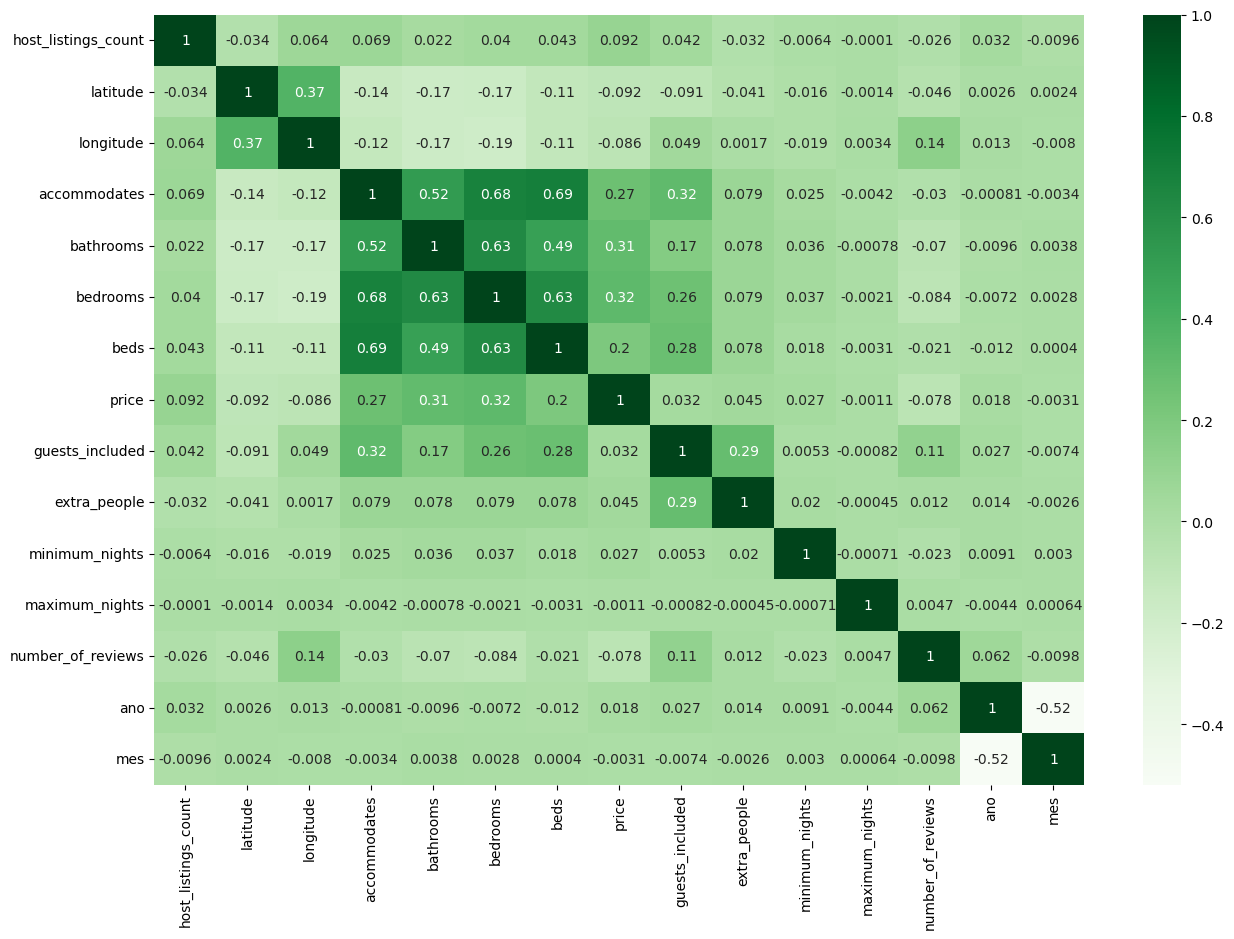

In [11]:
plt.figure(figsize=(15, 10))
sns.heatmap(base_airbnb.corr(numeric_only=True), annot=True, cmap='Greens')

### Definição de Funções para Análise de Outliers

- Vamos definir algumas funções para auxiliar na análise de outliers nas colunas.


In [12]:
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude

def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df, linhas_removidas
    

In [13]:
def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)
    
def histograma(coluna):
    plt.figure(figsize=(15, 5))
    sns.histplot(data=base_airbnb, x=coluna, kde=True, color='Blue')
    
def grafico_barra(coluna):
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x = coluna.value_counts().index, y = coluna.value_counts())
    ax.set_xlim(limites(coluna))
    


### price

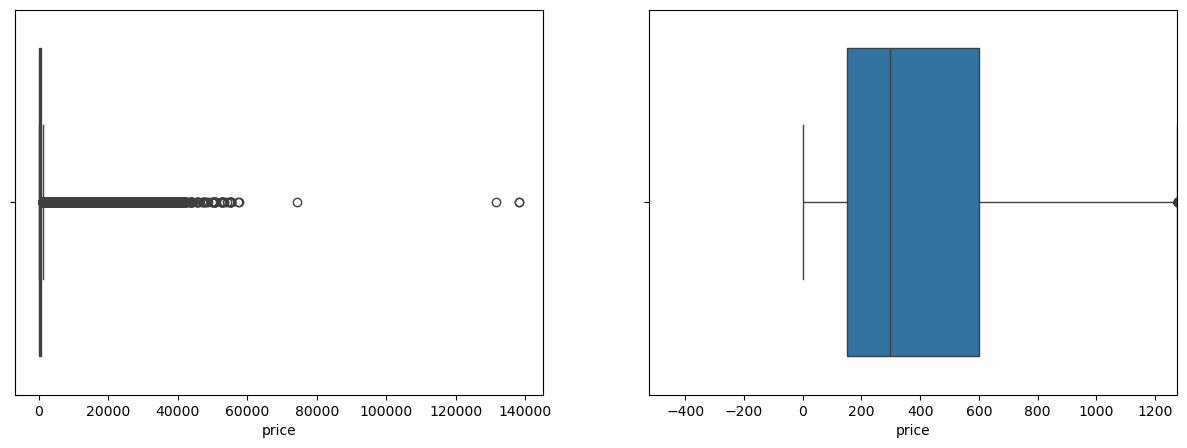

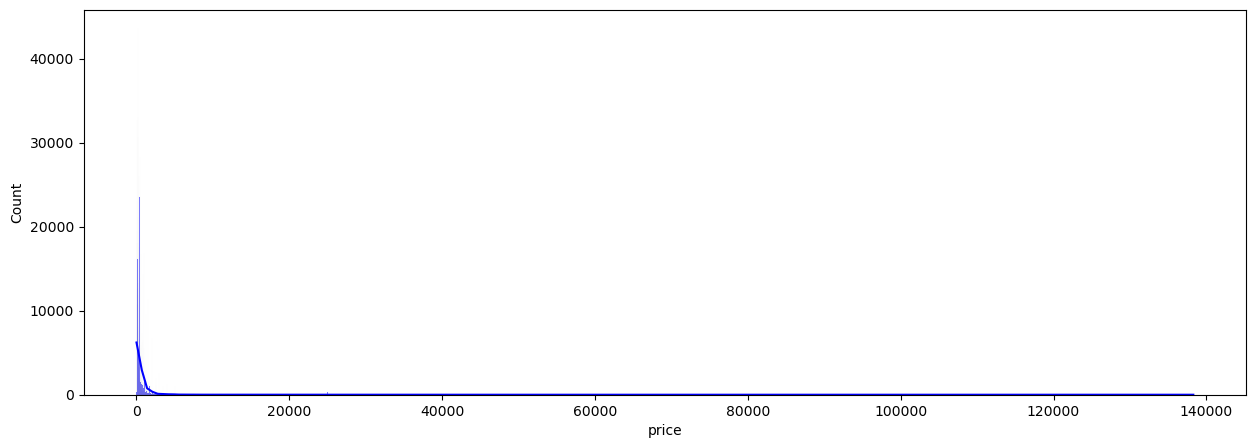

In [14]:
diagrama_caixa(base_airbnb['price'])
histograma(base_airbnb['price'])


- Como estamos construindo um modelo para imóveis comuns, acredito que os valores acima do limite superior correspondem apenas a apartamentos/imóveis de alto padrão, o que não é o objetivo principal. Portanto, podemos excluir esses outliers.


In [15]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'price')
print(f'{linhas_removidas}')

87282


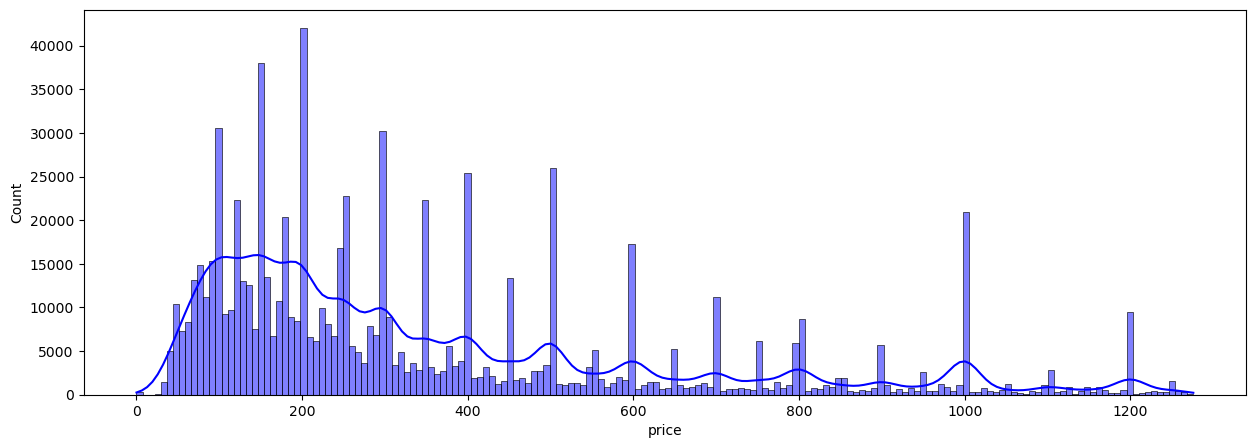

In [16]:
histograma(base_airbnb['price'])

### extra_people


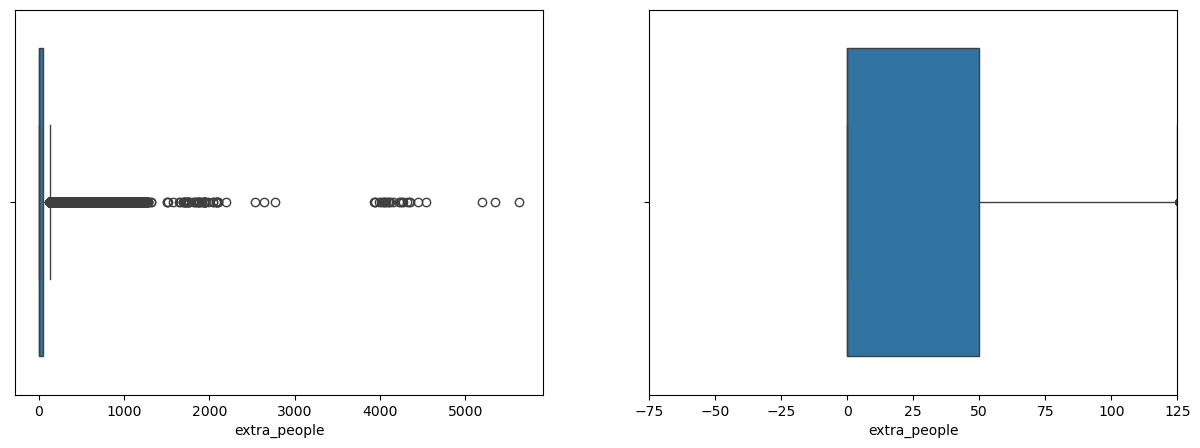

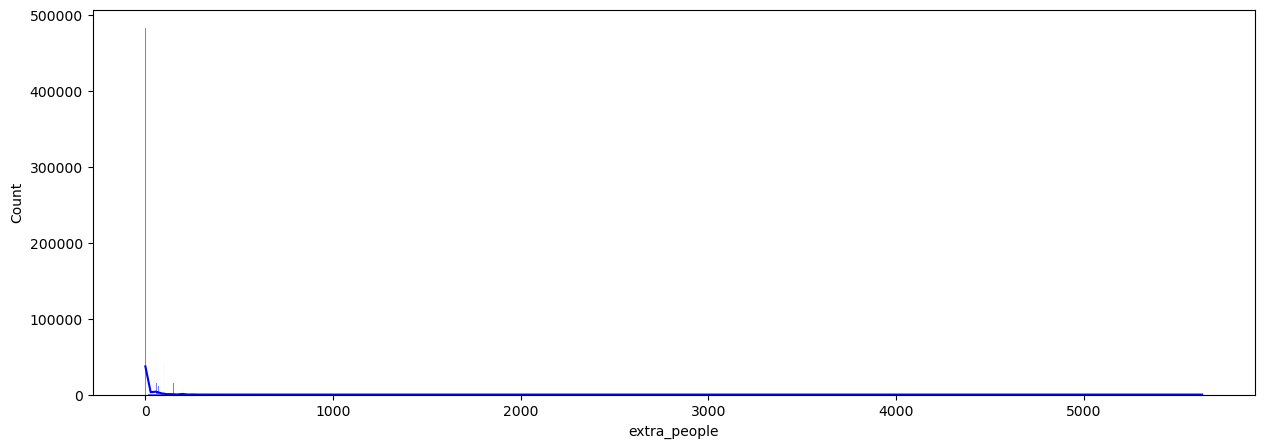

In [17]:
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])

In [18]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'extra_people')
print(f'{linhas_removidas}')

59194


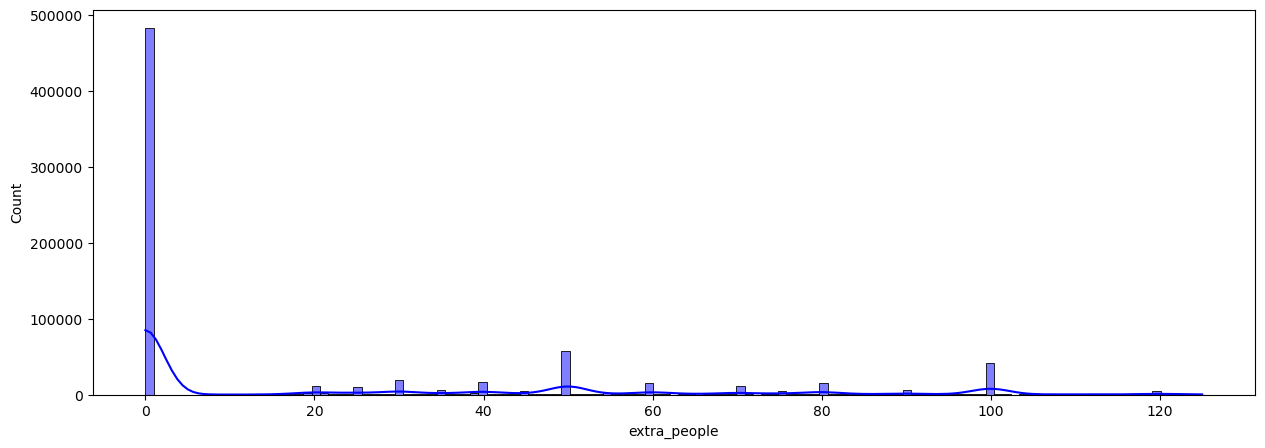

In [19]:
histograma(base_airbnb['extra_people'])

### host_listings_count

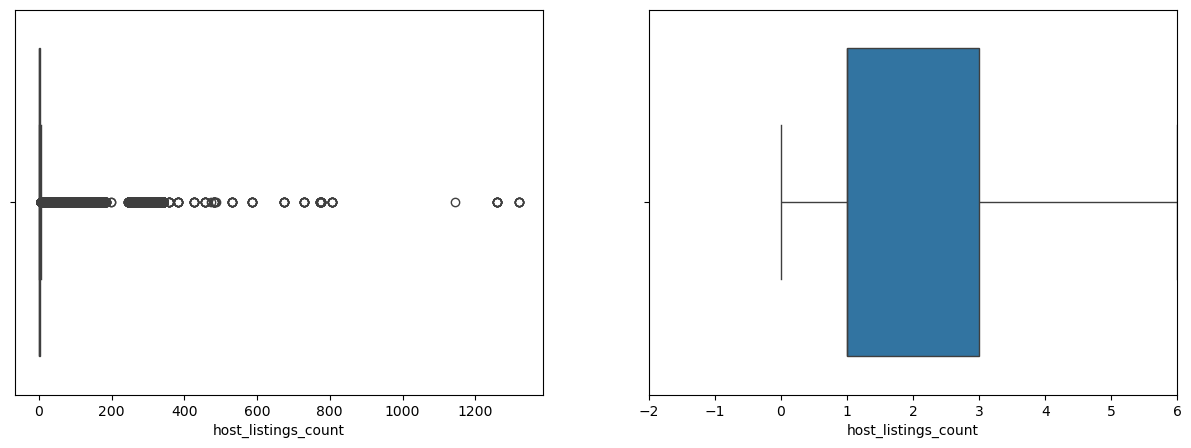

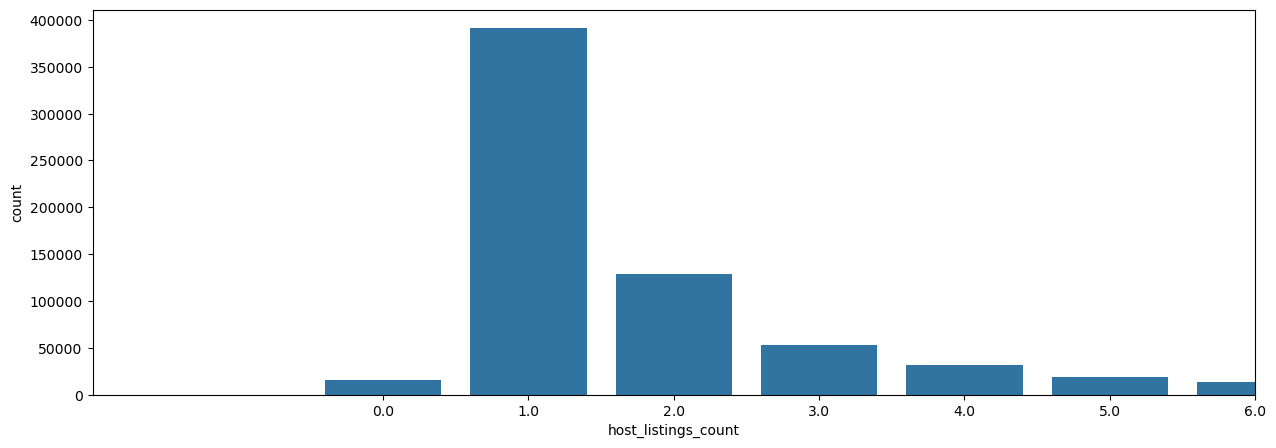

In [20]:
diagrama_caixa(base_airbnb['host_listings_count'])
grafico_barra(base_airbnb['host_listings_count'])

- Podemos excluir os outliers, pois hosts com mais de 6 imóveis no Airbnb não são o público-alvo do projeto.


In [21]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'host_listings_count')
print(f'{linhas_removidas}')


97723


### accommodates               

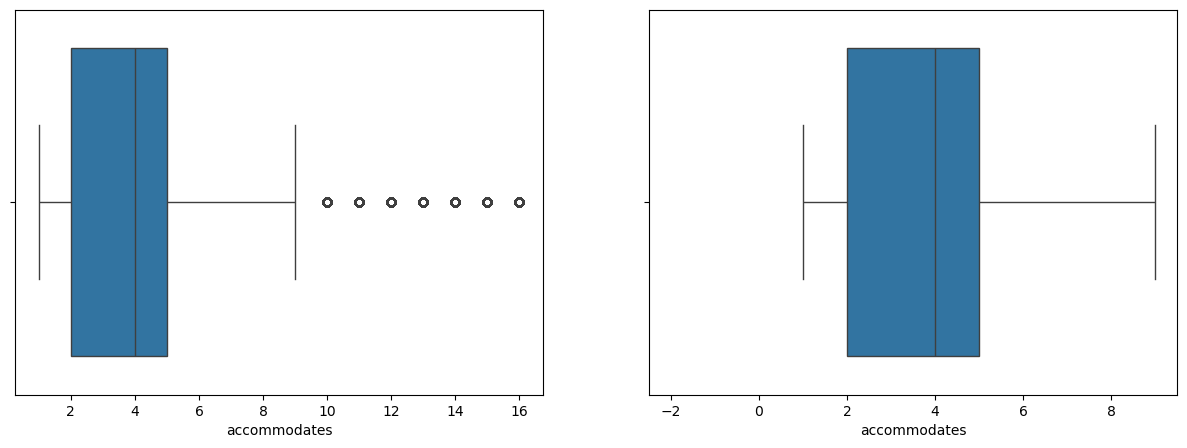

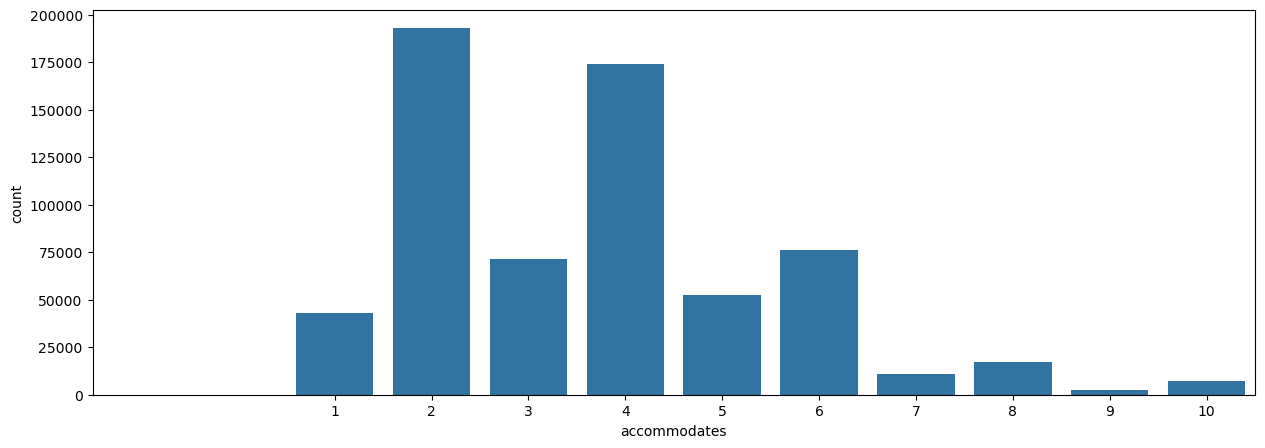

In [22]:
diagrama_caixa(base_airbnb['accommodates'])
grafico_barra(base_airbnb['accommodates'])

- Como o objetivo do nosso projeto é focar em imóveis padrão, iremos remover os outliers da coluna 'accommodates'. Imóveis com capacidade para um número muito alto de hóspedes não se alinham ao perfil de imóveis que estamos analisando.


In [23]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'accommodates')
print(f'{linhas_removidas}')


13146


### bathrooms

<Axes: xlabel='bathrooms', ylabel='count'>

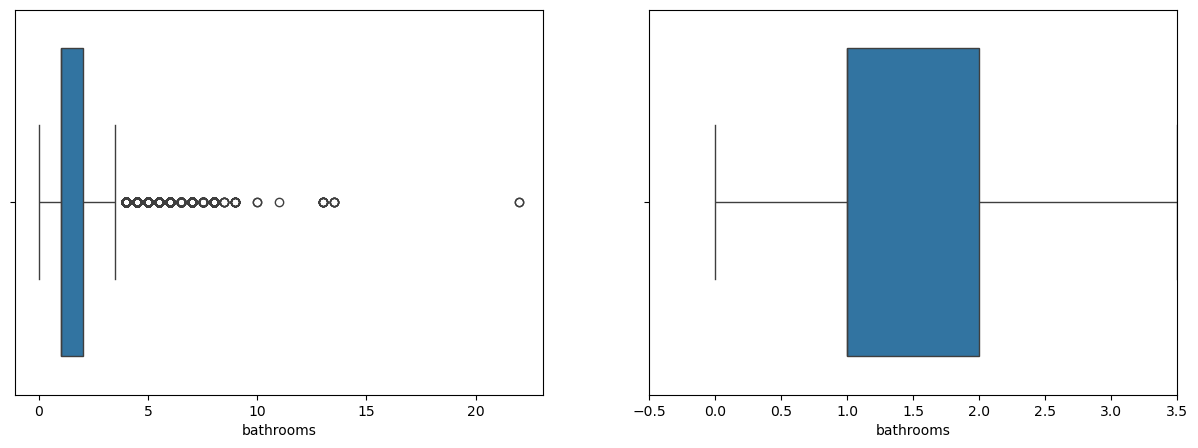

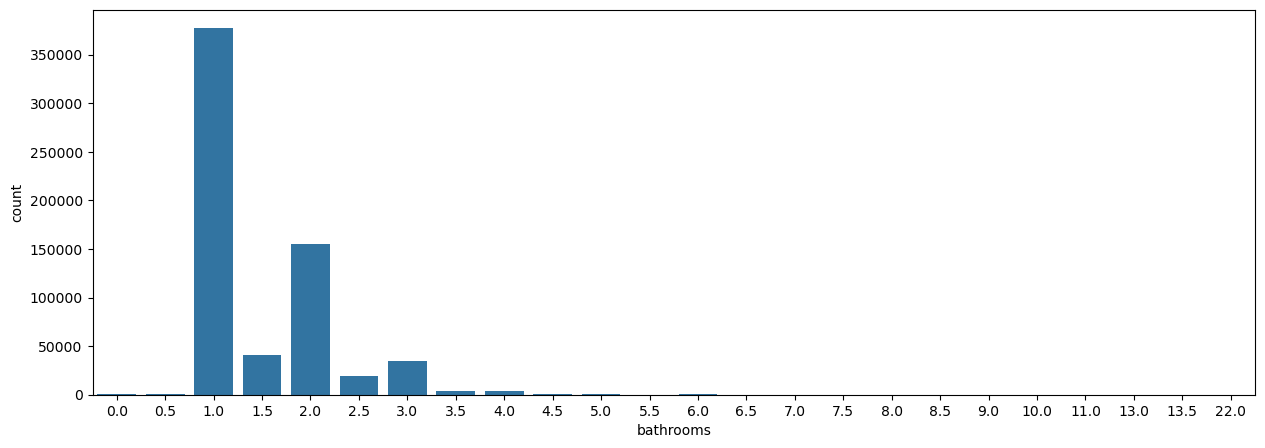

In [24]:
diagrama_caixa(base_airbnb['bathrooms'])
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['bathrooms'].value_counts().index, y=base_airbnb['bathrooms'].value_counts())

- 

In [25]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bathrooms')
print(f'{linhas_removidas}')


6894


### bedrooms

In [26]:
# diagrama_caixa(base_airbnb['bedrooms'])
# grafico_barra(base_airbnb['bedrooms'])


- 

In [27]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bedrooms')
print(f'{linhas_removidas}')

5482


### beds

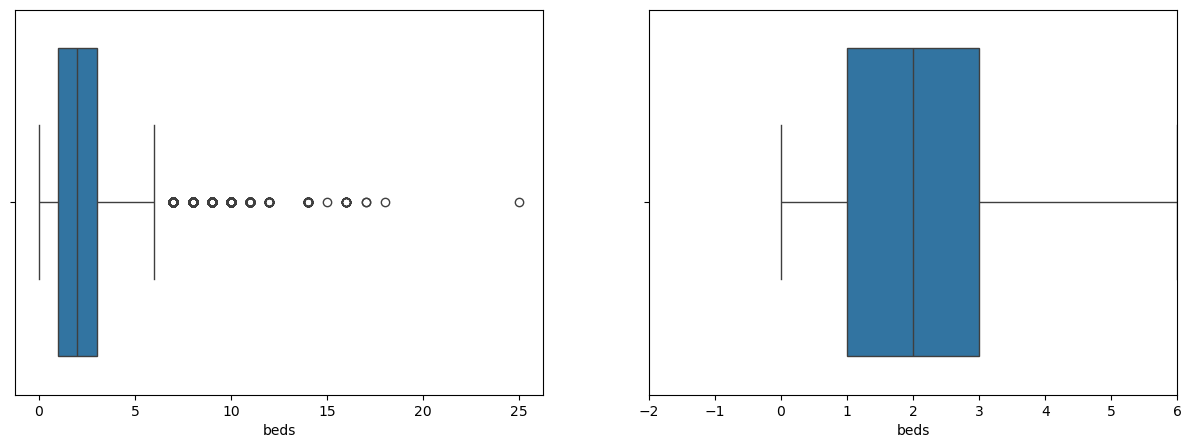

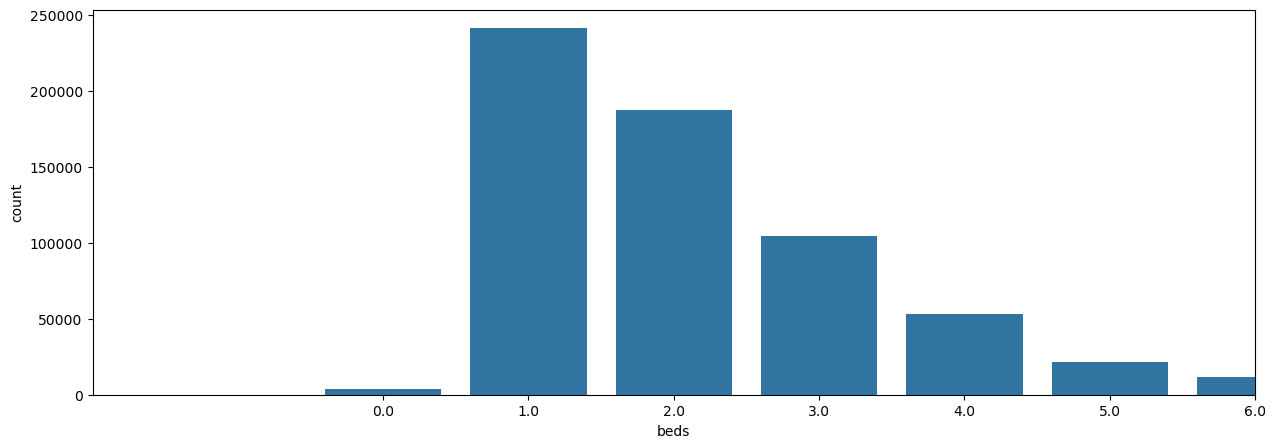

In [28]:
diagrama_caixa(base_airbnb['beds'])
grafico_barra(base_airbnb['beds'])

- 

In [29]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'beds')
print(f'{linhas_removidas}')

5622


### guests_included

<Axes: xlabel='guests_included', ylabel='count'>

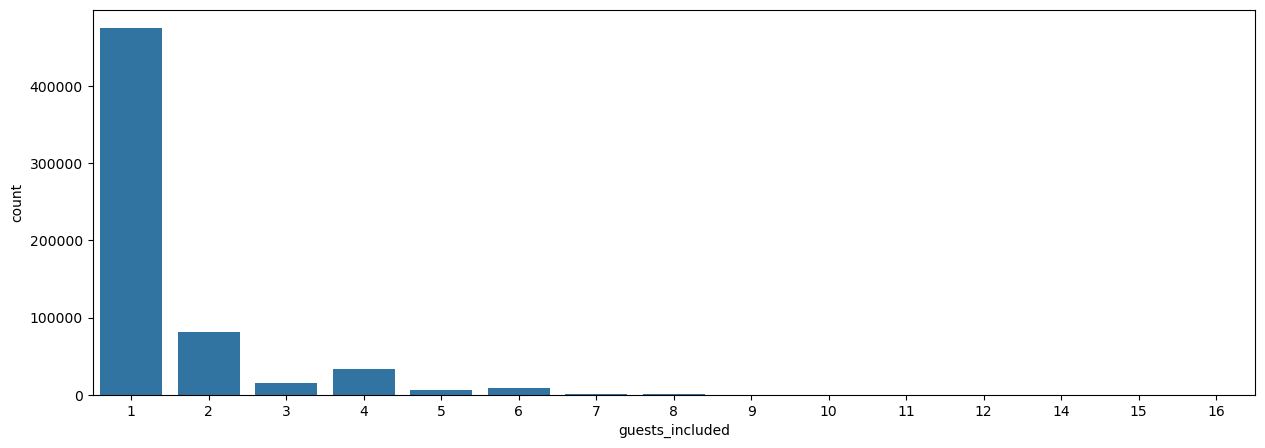

In [30]:
# diagrama_caixa(base_airbnb['guests_included'])
# grafico_barra(base_airbnb['guests_included'])
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['guests_included'].value_counts().index, y=base_airbnb['guests_included'].value_counts())

 - Vou remover a feature da análise. Parece que os usuários utilizavam o padrão como 1 em guests_included.
Isso pode levar nosso modelo a considerar uma feature que, na verdade, não é essencial para a definição do preço.


In [31]:
base_airbnb = base_airbnb.drop(['guests_included'], axis=1)
base_airbnb.shape

(622366, 22)

### minimum_nights

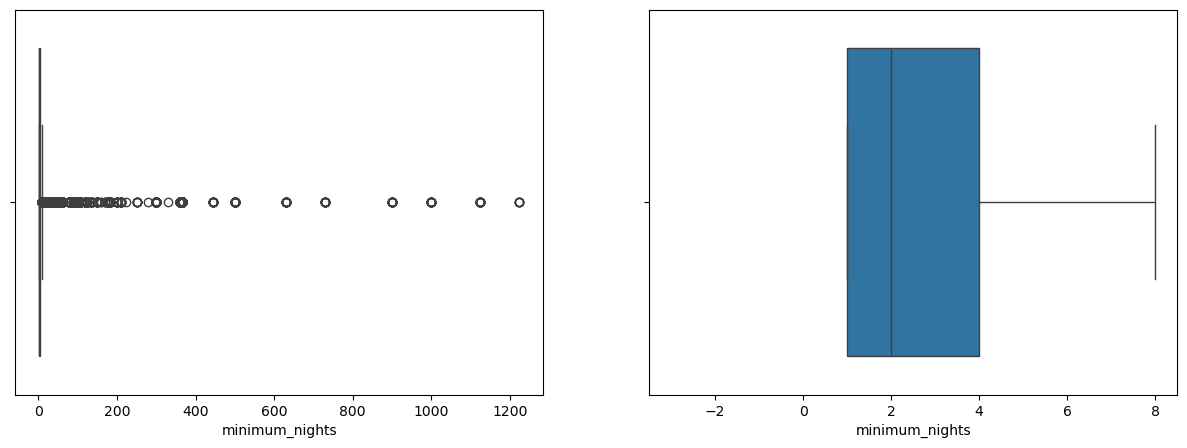

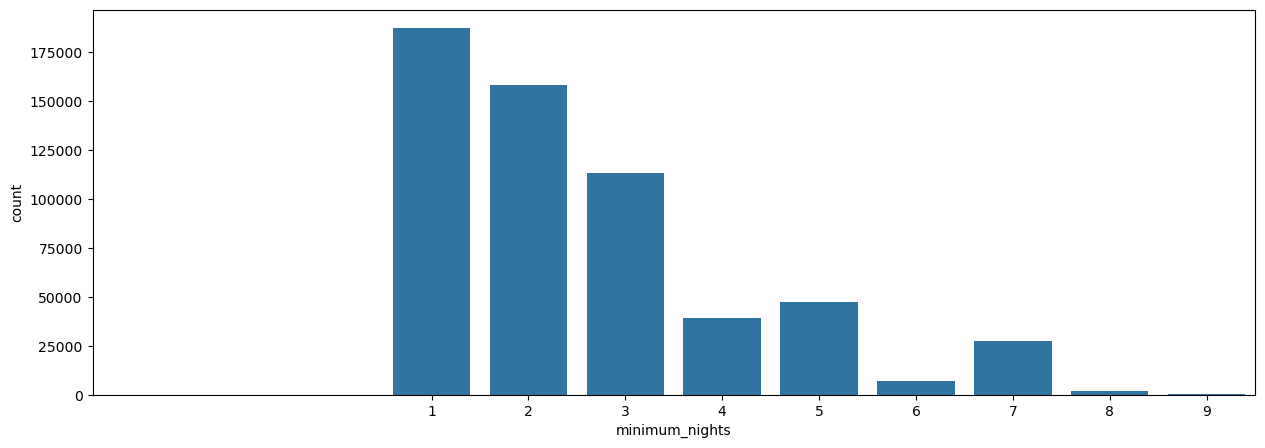

In [32]:
diagrama_caixa(base_airbnb['minimum_nights'])
grafico_barra(base_airbnb['minimum_nights'])

- 

In [33]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'minimum_nights')
print(f'{linhas_removidas}')

40383


### maximum_nights

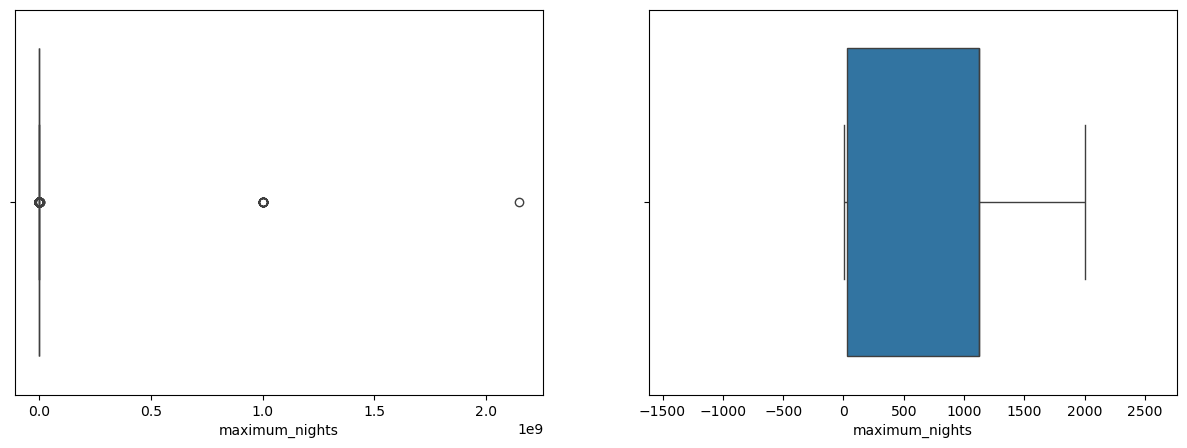

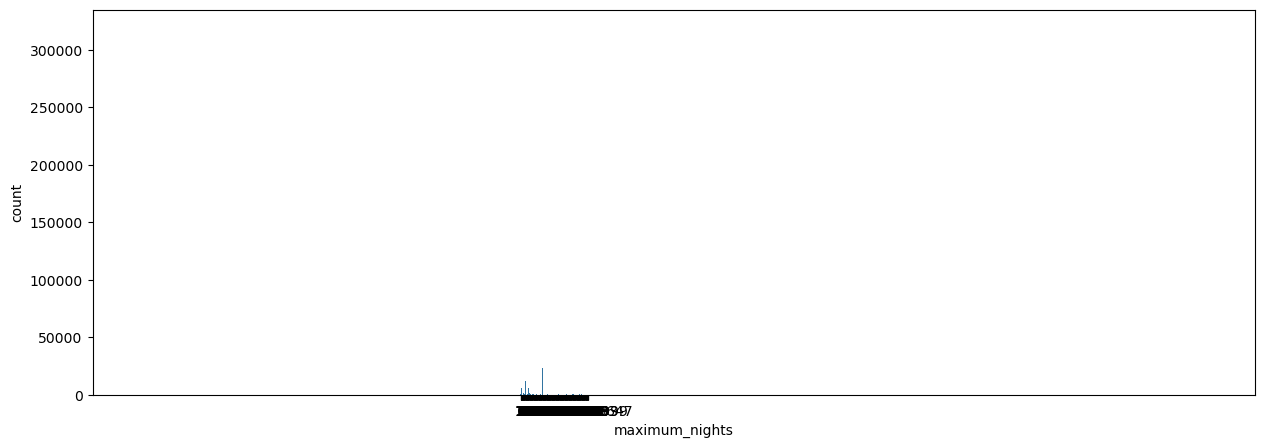

In [34]:
diagrama_caixa(base_airbnb['maximum_nights'])
grafico_barra(base_airbnb['maximum_nights'])

- Vou remover a feature da análise. Parece que os usuários utilizavam valores irreais em "maximum_nights".
Isso pode levar nosso modelo a considerar uma feature que, na verdade, não é essencial para a definição do preço.



In [35]:
base_airbnb = base_airbnb.drop(['maximum_nights'], axis=1)
base_airbnb.shape

(581983, 21)

### number_of_reviews

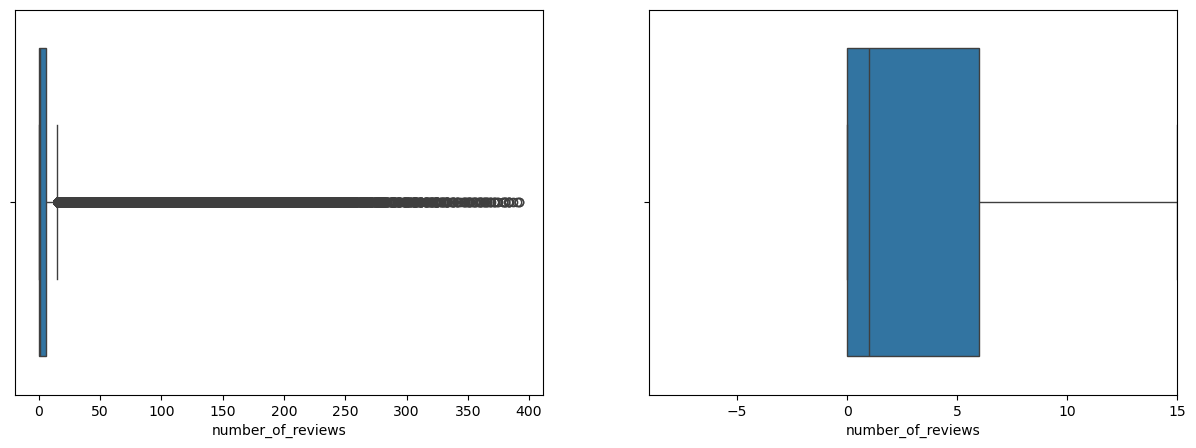

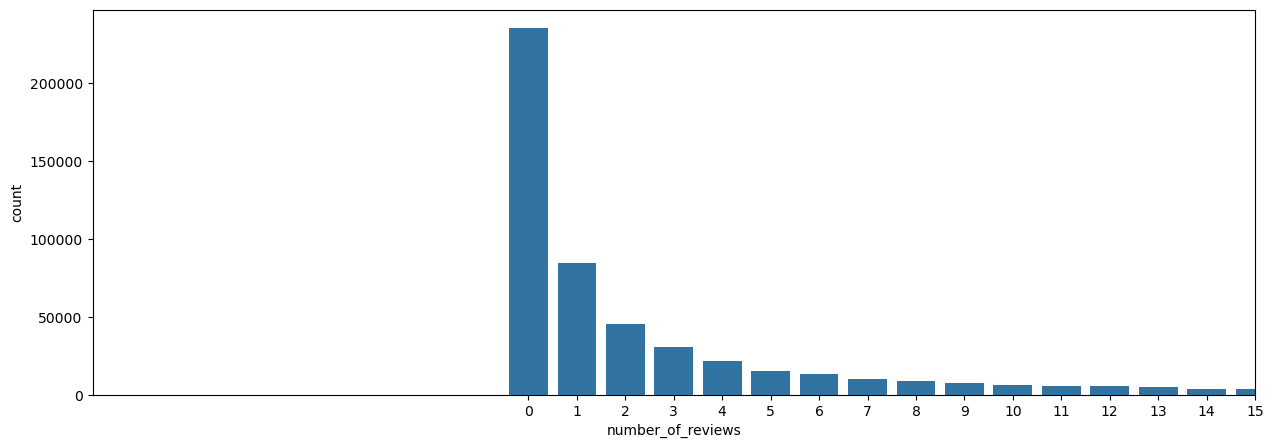

In [36]:
diagrama_caixa(base_airbnb['number_of_reviews'])
grafico_barra(base_airbnb['number_of_reviews'])

- Decidimos remover a feature maximum_nights da análise. Como o objetivo do modelo é auxiliar na definição de preços para imóveis em fase inicial de cadastro, não faz sentido considerar informações relacionadas a imóveis já estabelecidos na plataforma — especialmente aquelas que podem ter sido ajustadas ao longo do tempo ou que refletem práticas individuais não padronizadas.

In [37]:
base_airbnb = base_airbnb.drop(['number_of_reviews'], axis=1)
base_airbnb.shape

(581983, 20)

### Tratamento de Colunas de Valores de Texto


- property_type


property_type
Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                     

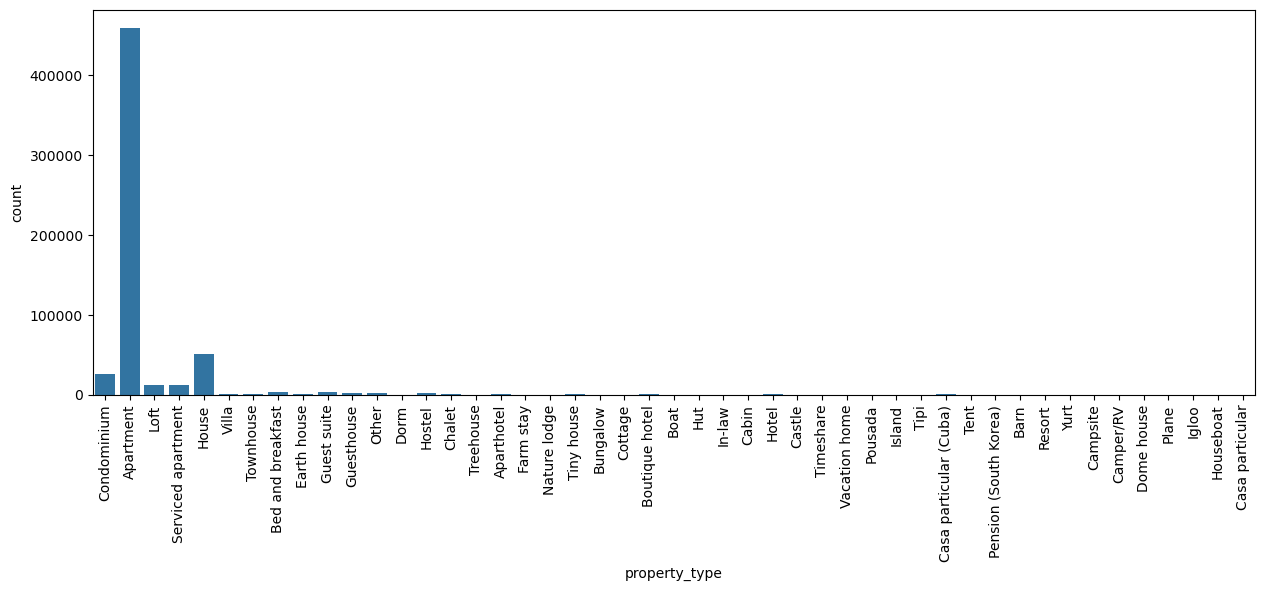

In [38]:
print(base_airbnb['property_type'].value_counts())
plt.figure(figsize=(15, 5 ))
grafico = sns.countplot(data=base_airbnb, x='property_type')
grafico.tick_params(axis='x', rotation=90)

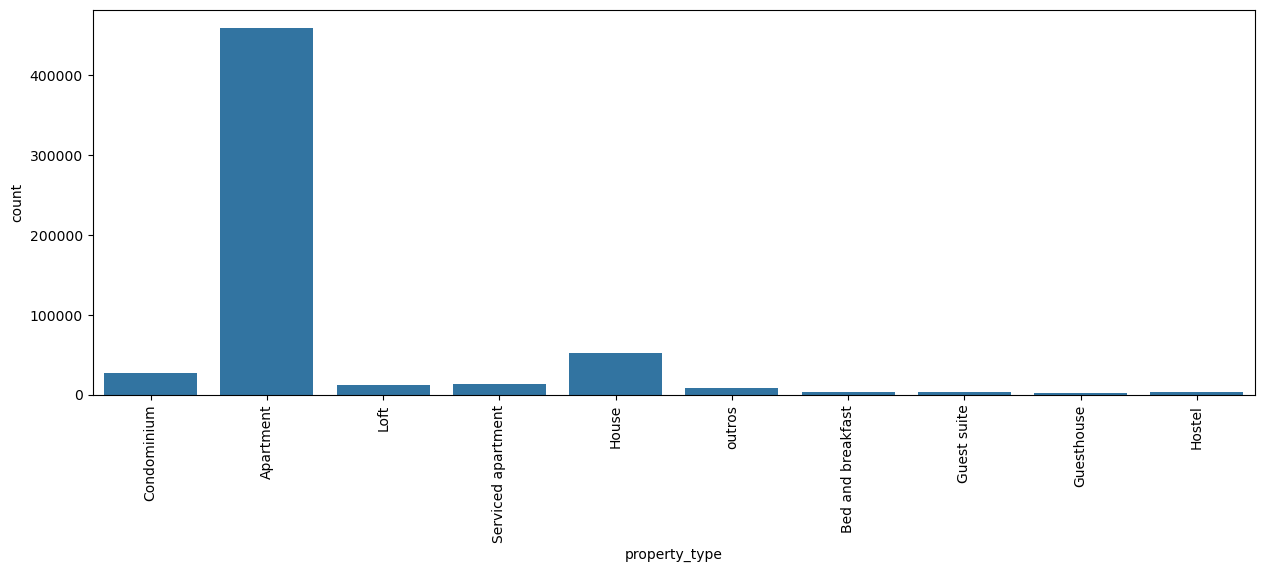

In [39]:
tabela_tipos_casa = base_airbnb['property_type'].value_counts()
colunas_agrupar = []
for tipo in tabela_tipos_casa.index:
    if tabela_tipos_casa[tipo] <= 2000:
        colunas_agrupar.append(tipo)
# print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['property_type']==tipo, 'property_type'] = 'outros'
# print(base_airbnb['property_type'].value_counts())

plt.figure(figsize=(15, 5 ))
grafico = sns.countplot(data=base_airbnb, x='property_type')
grafico.tick_params(axis='x', rotation=90)


- room_type

room_type
Entire home/apt    372443
Private room       196859
Shared room         11714
Hotel room            967
Name: count, dtype: int64


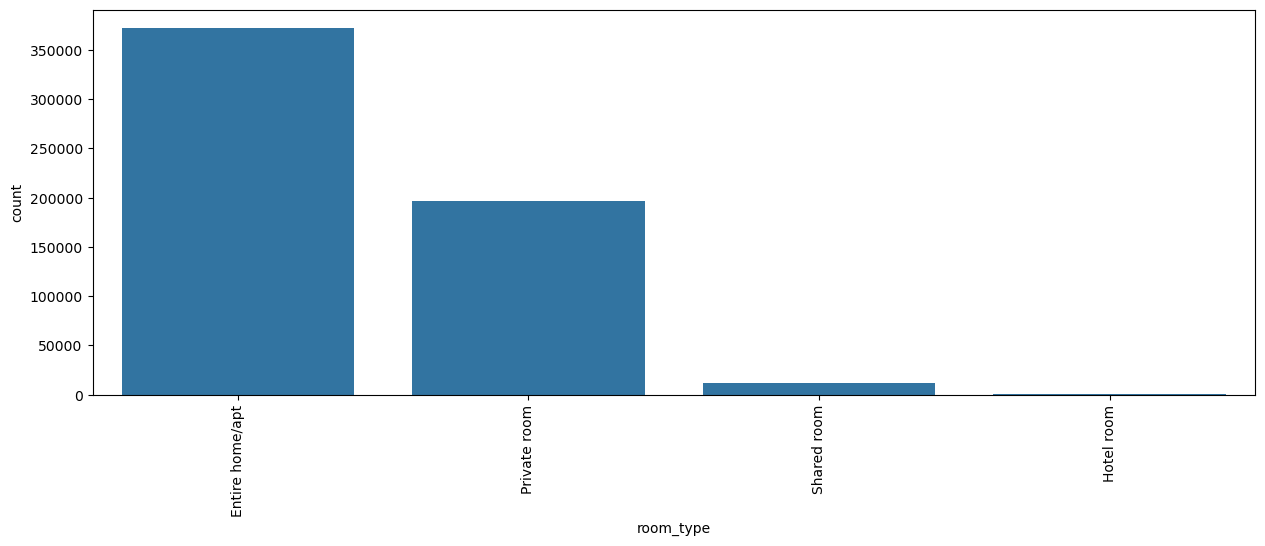

In [40]:
print(base_airbnb['room_type'].value_counts())
plt.figure(figsize=(15, 5 ))
grafico = sns.countplot(data=base_airbnb, x='room_type')
grafico.tick_params(axis='x', rotation=90)

- bed_type

bed_type
Real Bed         570643
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               496
Name: count, dtype: int64


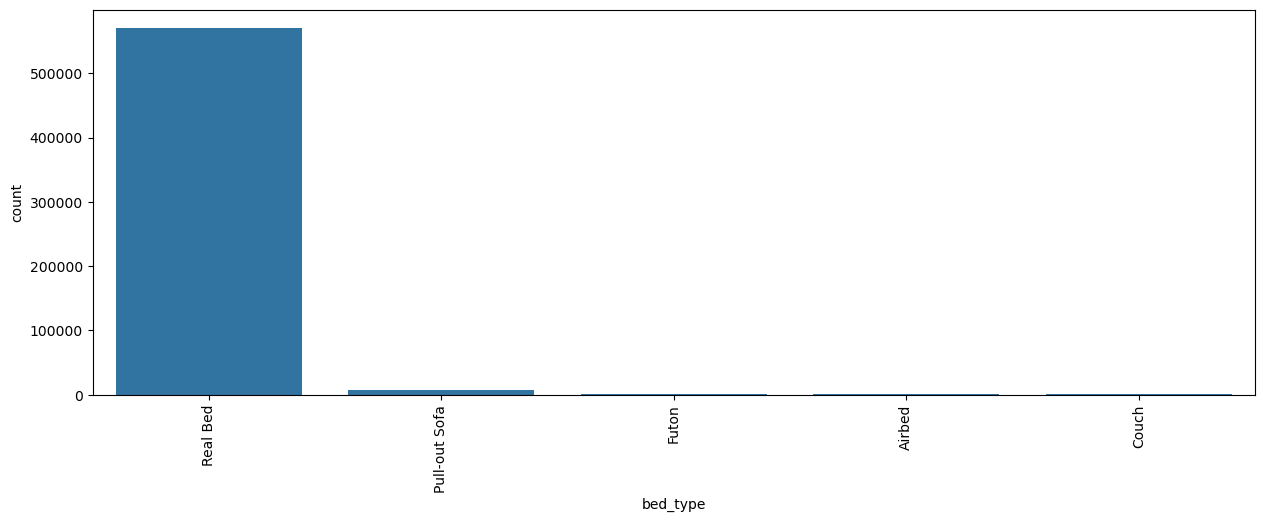

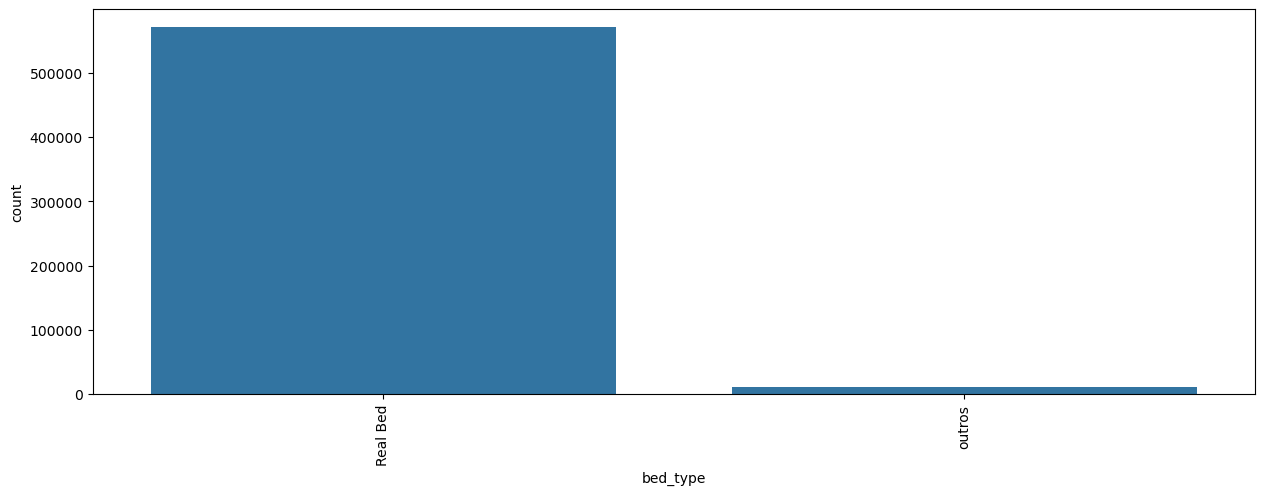

In [41]:
print(base_airbnb['bed_type'].value_counts())
plt.figure(figsize=(15, 5 ))
grafico = sns.countplot(data=base_airbnb, x='bed_type')
grafico.tick_params(axis='x', rotation=90)

# Agrupando categorias de bed_type
tabela_bed_type = base_airbnb['bed_type'].value_counts()
colunas_agrupar = []
for tipo in tabela_bed_type.index:
    if tabela_bed_type[tipo] <= 10000:
        colunas_agrupar.append(tipo)
# print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['bed_type']==tipo, 'bed_type'] = 'outros'
# print(base_airbnb['property_type'].value_counts())

plt.figure(figsize=(15, 5 ))
grafico = sns.countplot(data=base_airbnb, x='bed_type')
grafico.tick_params(axis='x', rotation=90)


- cancellation_policy

cancellation_policy
flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9696
super_strict_60                   135
super_strict_30                    32
Name: count, dtype: int64


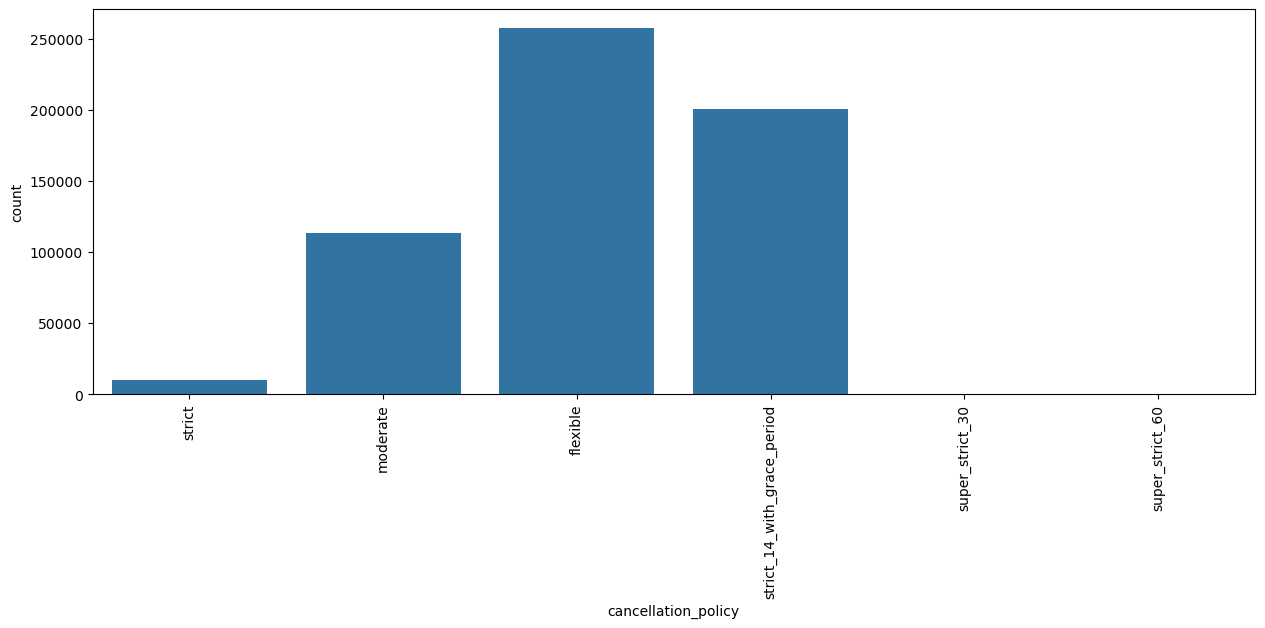

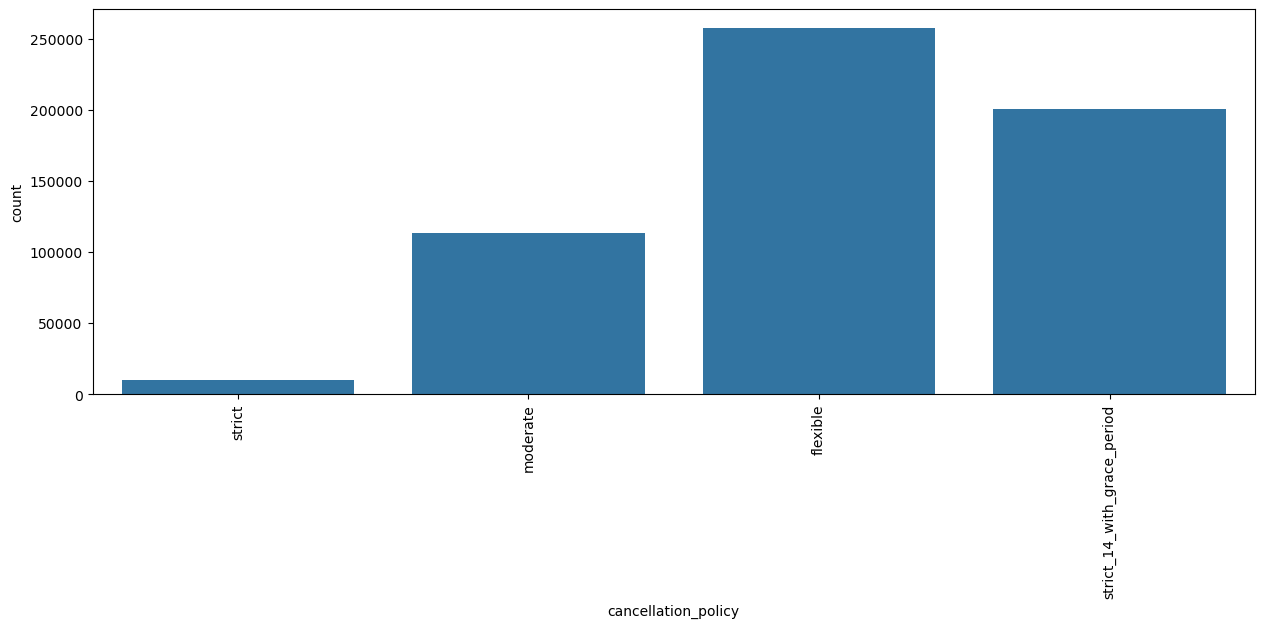

In [42]:
print(base_airbnb['cancellation_policy'].value_counts())
plt.figure(figsize=(15, 5 ))
grafico = sns.countplot(data=base_airbnb, x='cancellation_policy')
grafico.tick_params(axis='x', rotation=90)

# Agrupando categorias de cancellation_policy
tabela_cancellation = base_airbnb['cancellation_policy'].value_counts()
colunas_agrupar = []
for tipo in tabela_cancellation.index:
    if tabela_cancellation[tipo] <= 10000:
        colunas_agrupar.append(tipo)
# print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['cancellation_policy']==tipo, 'cancellation_policy'] = 'strict'
# print(base_airbnb['property_type'].value_counts())

plt.figure(figsize=(15, 5 ))
grafico = sns.countplot(data=base_airbnb, x='cancellation_policy')
grafico.tick_params(axis='x', rotation=90)


- Amenities

Como temos uma grande diversidade de amenities e, às vezes, as mesmas podem ser descritas de formas diferentes, vamos analisar a quantidade de amenities a ser considerada no nosso modelo.

In [43]:
print(base_airbnb['amenities'].iloc[1].split(','))
print(len(base_airbnb['amenities'].iloc[1].split(',')))

base_airbnb['nr_amenities'] = base_airbnb['amenities'].str.split(',').apply(len)

base_airbnb = base_airbnb.drop(['amenities'], axis=1)
base_airbnb.shape



['{TV', '"Cable TV"', 'Internet', 'Wifi', '"Air conditioning"', 'Kitchen', 'Doorman', 'Elevator', '"Buzzer/wireless intercom"', '"Family/kid friendly"', 'Hangers', '"Hair dryer"', 'Iron', '"Laptop friendly workspace"}']
14


(581983, 20)

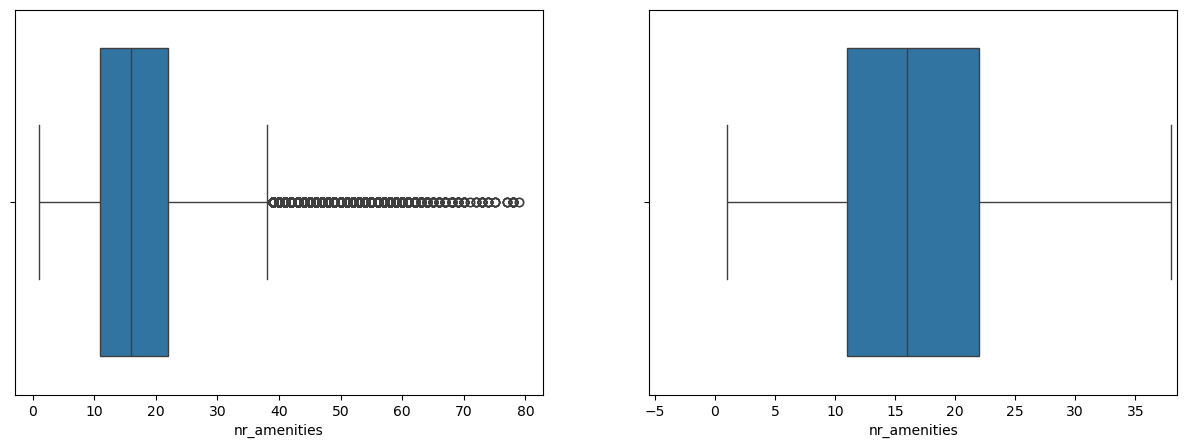

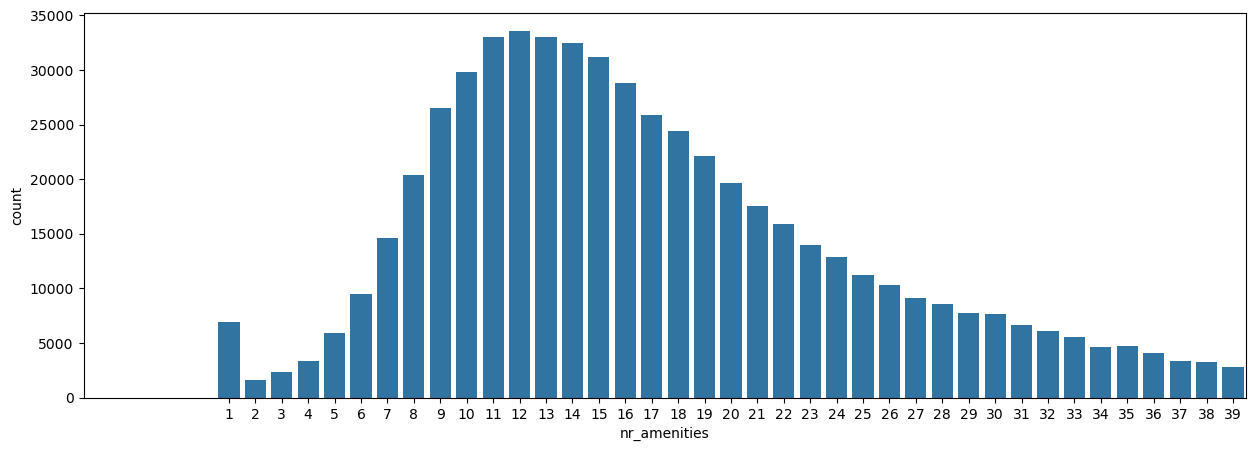

In [44]:
diagrama_caixa(base_airbnb['nr_amenities'])
grafico_barra(base_airbnb['nr_amenities'])

In [45]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'nr_amenities')
print(f'{linhas_removidas}')

24343


### Visualização de Mapa das Propriedades

In [46]:
amostra = base_airbnb.sample(n=20000)
centro_mapa = {'lat': amostra.latitude.mean(), 'lon': amostra.longitude.mean()}
mapa = px.density_mapbox(amostra, lat='latitude', lon='longitude', z='price', radius=2.5,
                         center=centro_mapa, zoom=10, mapbox_style='carto-positron')

mapa.show()

### Encoding
 - Precisamos ajustar as features para facilitar o trabalho do modelo futuro (features de categoria, True/False, etc.).

Features com valores True ou False: Vamos substituir True por 1 e False por 0.

Features de categoria (features em que os valores da coluna são textos): Vamos utilizar o método de Encoding de Variáveis Dummies.

In [47]:
colunas_tf = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready']
base_airbnb_cod = base_airbnb.copy()

for coluna in colunas_tf:
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='t', coluna] = 1
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='f', coluna] = 0


In [48]:
colunas_categorias = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']
base_airbnb_cod = pd.get_dummies(data=base_airbnb_cod, columns=colunas_categorias, dtype=int)

display(base_airbnb_cod.head())

host_is_superhost  host_listings_count   latitude  longitude  accommodates  \
1                 1                  2.0 -22.965919 -43.178962             5   
3                 0                  3.0 -22.977117 -43.190454             3   
4                 1                  1.0 -22.983024 -43.214270             3   
5                 1                  1.0 -22.988165 -43.193588             3   
6                 1                  1.0 -22.981269 -43.190457             2   

   bathrooms  bedrooms  beds  price  extra_people  ...  \
1        1.0       2.0   2.0  270.0          51.0  ...   
3        1.0       1.0   2.0  161.0          45.0  ...   
4        1.0       1.0   2.0  222.0          68.0  ...   
5        1.5       1.0   2.0  308.0          86.0  ...   
6        1.0       1.0   2.0  219.0          80.0  ...   

   room_type_Entire home/apt room_type_Hotel room room_type_Private room  \
1                          1                    0                      0   
3                          1                    0                      0   
4                          1                    0                      0   
5                          1                    0                      0   
6                          1                    0                      0   

   room_type_Shared room  bed_type_Real Bed  bed_type_outros  \
1                      0                  1                0   
3                      0                  1                0   
4                      0                  1                0   
5                      0                  1                0   
6                      0                  1                0   

   cancellation_policy_flexible  cancellation_policy_moderate  \
1                             0                             0   
3                             0                             0   
4                             0                             0   
5                             0                             0   
6                             0                             0   

   cancellation_policy_strict  cancellation_policy_strict_14_with_grace_period  
1                           1                                                0  
3                           1                                                0  
4                           1                                                0  
5                           1                                                0  
6                           1                                                0  

[5 rows x 36 columns]

### Modelo de Previsão

- Métricas de Avaliação

In [49]:
def avaliar_modelo(nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao)
    RSME = np.sqrt(mean_squared_error(y_teste, previsao))
    return f'Modelo{nome_modelo}:\nR²{r2:.2%}\nRSME:{RSME:.2f}'

- Escolha dos modelos a Serem testados

    1.RandomForest

    2.LinearRegression

    3.Extra Tree
     
 

In [50]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()

modelos = {'RandomForest': modelo_rf,
          'LinearRegression': modelo_lr,
          'ExtraTrees': modelo_et,
          }

y = base_airbnb_cod['price']
x = base_airbnb_cod.drop('price', axis=1)

- Separação dos dados em treino e teste + Treino do Modelo

In [51]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)

for nome_modelo, modelo in modelos.items():
    #treinar
    modelo.fit(x_train, y_train)
    #testar
    previsao = modelo.predict(x_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

ModeloRandomForest:
R²97.23%
RSME:44.15
ModeloLinearRegression:
R²32.70%
RSME:217.54
ModeloExtraTrees:
R²97.51%
RSME:41.86


### Análise do Melhor Modelo

In [52]:
for nome_modelo, modelo in modelos.items():
    #testar
    previsao = modelo.predict(x_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

ModeloRandomForest:
R²97.23%
RSME:44.15
ModeloLinearRegression:
R²32.70%
RSME:217.54
ModeloExtraTrees:
R²97.51%
RSME:41.86


- Modelo Escolhido: ExtraTreesForest

O ExtraTreesForest foi o modelo que apresentou o maior valor de R² e, ao mesmo tempo, o menor valor de RMSE. Como não houve uma grande diferença no tempo de treino e de previsão entre este modelo e o RandomForest (que obteve resultados próximos em R² e RMSE), optamos por escolher o ExtraTreesForest. Já o modelo de Regressão Linear não obteve resultados satisfatórios, com valores de R² e RMSE significativamente inferiores aos dos outros modelos.

Resultados do Modelo Escolhido:

Modelo: ExtraTreesForest

R²: 97,51%

RMSE: 41,86



### Ajustes e Melhorias no Melhor Modelo

0
bedrooms                                         0.112037
latitude                                         0.103982
longitude                                        0.101337
nr_amenities                                     0.088668
extra_people                                     0.085239
bathrooms                                        0.075287
accommodates                                     0.074290
minimum_nights                                   0.065688
room_type_Entire home/apt                        0.061401
beds                                             0.052769
host_listings_count                              0.039693
instant_bookable                                 0.022029
cancellation_policy_flexible                     0.019539
host_is_superhost                                0.013737
property_type_Apartment                          0.012966
cancellation_policy_moderate                     0.012245
ano                                              0.011307
cancellation_policy_strict_14_with_grace_period  0.007692
property_type_House                              0.007081
property_type_Condominium                        0.005209
mes                                              0.004706
room_type_Private room                           0.004370
bed_type_Real Bed                                0.002760
bed_type_outros                                  0.002600
property_type_outros                             0.002400
property_type_Serviced apartment                 0.002268
property_type_Loft                               0.002171
room_type_Shared room                            0.001828
property_type_Bed and breakfast                  0.001296
property_type_Guesthouse                         0.000930
cancellation_policy_strict                       0.000853
property_type_Guest suite                        0.000679
property_type_Hostel                             0.000633
room_type_Hotel room                             0.000310
is_business_travel_ready                         0.000000

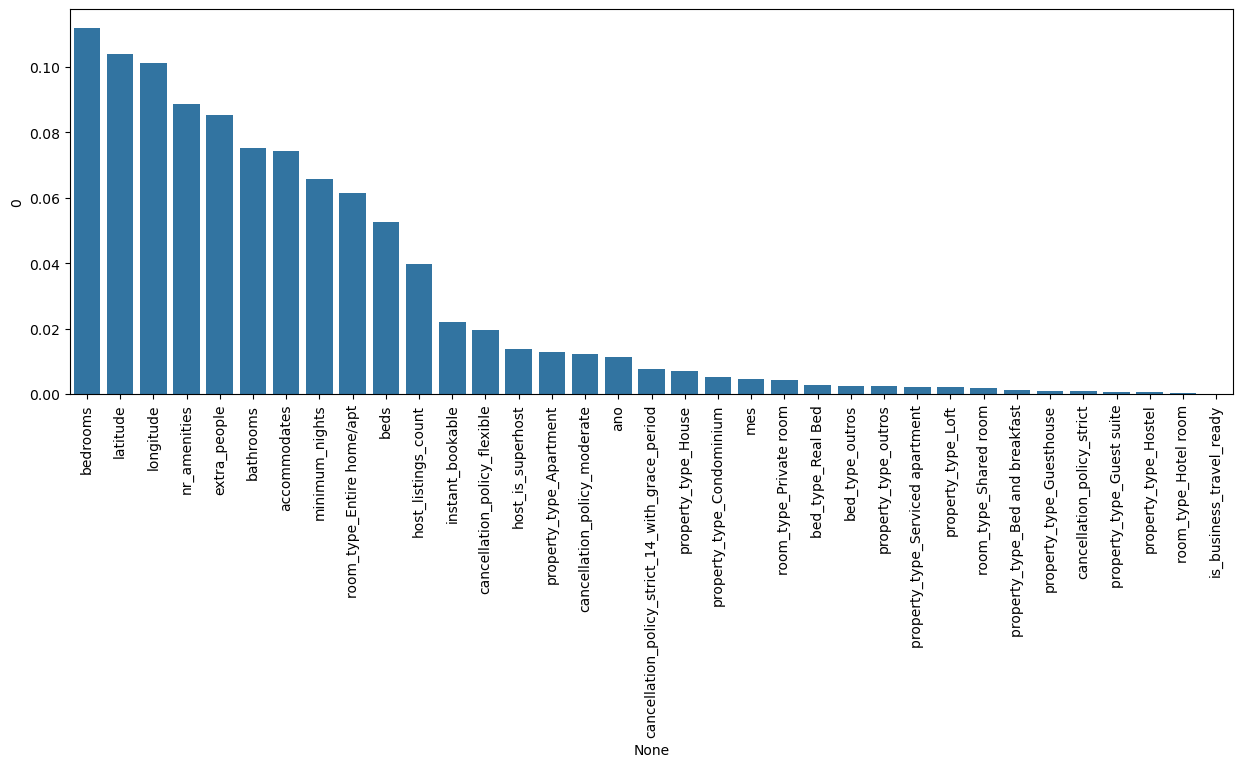

In [62]:
# print(modelo_et.feature_importances_)
# print(x_train.columns)

importancia_features = pd.DataFrame(modelo_et.feature_importances_, x_train.columns)
importancia_features = importancia_features.sort_values(by=0, ascending=False)
display(importancia_features)
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features[0])
ax.tick_params(axis='x', rotation=90)

### Ajustes Finais do Modelo
A feature is_business_travel_ready não parece ter impactado nosso modelo. Por isso, para simplificar o modelo, vamos excluí-la e testar o desempenho sem essa variável.

In [69]:
base_airbnb_cod = base_airbnb_cod.drop('is_business_travel_ready', axis=1)
y = base_airbnb_cod['price']
x = base_airbnb_cod.drop('price', axis=1 )

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)

modelo_et.fit(x_train, y_train)
previsao = modelo_et.predict(x_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

35

ModeloExtraTrees:
R²97.51%
RSME:41.85


In [78]:
base_teste = base_airbnb_cod.copy()
for coluna in base_teste:
    if 'bed_type' in coluna:
        base_teste = base_teste.drop(coluna, axis=1)
print(base_teste.columns)
y = base_teste['price']
x = base_teste.drop('price', axis=1 )

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)

modelo_et.fit(x_train, y_train)
previsao = modelo_et.predict(x_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'extra_people', 'minimum_nights', 'instant_bookable', 'ano', 'mes',
       'nr_amenities', 'property_type_Apartment',
       'property_type_Bed and breakfast', 'property_type_Condominium',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_House', 'property_type_Loft',
       'property_type_Serviced apartment', 'property_type_outros',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room',
       'cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period'],
      dtype='object')
ModeloExtraTrees:
R²97.49%
RSME:42.04


### Deploy do Projeto

In [79]:
x['price'] = y
x.to_csv('dados.csv')

In [80]:
import joblib

joblib.dump(modelo_et, 'modelo.joblib')

['modelo.joblib']